In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re #Regular expression 
import nltk # netural language toolkit
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


In [ ]:
dataset = pd.read_csv('IMDB Dataset.csv')
#dataset.shape() #rows and column in data
dataset.head() #to see first few datas

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
dataset.loc[dataset['sentiment'] == 'positive', 'sentiment'] = 1
dataset.loc[dataset['sentiment'] == 'negative', 'sentiment'] = 0
dataset.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


<h3>cleaning</h3>

In [ ]:
nltk.download('stopwords')
ps = PorterStemmer()
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\darkt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
corpus=[] #storing customer review

for i in range(0, 50000):
    review = re.sub('[^a-zA-Z]', ' ', dataset['review'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
#corpus[:6]

<h3>data transform

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1420) #top 1420 most frequent token

In [ ]:
X = cv.fit_transform(corpus).toarray()
y = dataset.iloc[:, -1].values
y=y.astype('int')

In [ ]:
# # Saving BoW dictionary to later use in prediction
# import pickle
# bow_path = 'c1_BoW_Sentiment_Model.pkl'
# pickle.dump(cv, open(bow_path, "wb"))

<h3>train:test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

In [ ]:
dataset.sentiment.unique()

array([1, 0], dtype=object)

<h2>model fitting: SVM

In [ ]:
from sklearn.svm import LinearSVC
svm_classifier = LinearSVC(dual=False, max_iter= 10000 )
svm_classifier.fit(X_train, y_train, )

LinearSVC(dual=False, max_iter=10000)

In [ ]:
# Exporting NB Classifier to later use in prediction
# import joblib
# joblib.dump(svm_classifier, 'c2_Classifier_Sentiment_Model') 

In [ ]:
y_pred = svm_classifier.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)

accuracy_svm = accuracy_score(y_test, y_pred)
accuracy_svm

[[3256  540]
 [ 437 3267]]


0.8697333333333334

<h3>model fitting: LSTM

In [ ]:
import keras
# from keras.models import Sequential
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 

In [ ]:
# Encoded the target column
from sklearn.preprocessing import LabelEncoder
reviews = dataset['review'].values
labels = dataset['sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [ ]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews,  encoded_labels, stratify = encoded_labels, test_size = 0.15)

In [ ]:
# Hyperparameters of the model
vocab_size = 3000 # choose based on statistics
oov_tok = ''
embedding_dim = 100
max_length = 200 # choose based on statistics, for example 150 to 200
padding_type='post'
trunc_type='post'
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [ ]:
# model initialization
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(256)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
# model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 100)          300000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 24)                6168      
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 540,689
Trainable params: 540,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 10
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)

Epoch 1/10
1196/1196 [==============================] - 74s 54ms/step - loss: 0.4890 - accuracy: 0.7665 - val_loss: 0.3167 - val_accuracy: 0.8682
Epoch 2/10
1196/1196 [==============================] - 63s 53ms/step - loss: 0.3285 - accuracy: 0.8649 - val_loss: 0.2897 - val_accuracy: 0.8831
Epoch 3/10
1196/1196 [==============================] - 68s 56ms/step - loss: 0.2900 - accuracy: 0.8837 - val_loss: 0.2975 - val_accuracy: 0.8784
Epoch 4/10
1196/1196 [==============================] - 67s 56ms/step - loss: 0.2437 - accuracy: 0.9038 - val_loss: 0.2928 - val_accuracy: 0.8819
Epoch 5/10
1196/1196 [==============================] - 62s 52ms/step - loss: 0.2081 - accuracy: 0.9198 - val_loss: 0.2882 - val_accuracy: 0.8791
Epoch 6/10
1196/1196 [==============================] - 73s 61ms/step - loss: 0.1776 - accuracy: 0.9330 - val_loss: 0.3191 - val_accuracy: 0.8779
Epoch 7/10
1196/1196 [==============================] - 69s 58ms/step - loss: 0.1495 - accuracy: 0.9453 - val_loss: 0.3254 -

In [ ]:
from sklearn.metrics import accuracy_score
prediction = model.predict(test_padded)
# Get labels based on probability 1 if p>= 0.5 else 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
accuracy_lstm = accuracy_score(test_labels,pred_labels)
print("Accuracy of prediction on test set : ", accuracy_lstm)

235/235 [==============================] - 4s 14ms/step
Accuracy of prediction on test set :  0.8686666666666667


<h3>model fitting: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=175, random_state=0, warm_start = True)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=175, random_state=0, warm_start=True)

In [ ]:
# Exporting NB Classifier to later use in prediction
# import joblib
# joblib.dump(rf_classifier, 'c2_Classifier_Sentiment_Model') 

In [ ]:
y_pred = rf_classifier.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)

accuracy_rf = accuracy_score(y_test, y_pred)
accuracy_rf

[[3179  617]
 [ 585 3119]]


0.8397333333333333

<h3>comparison among the models

<BarContainer object of 3 artists>

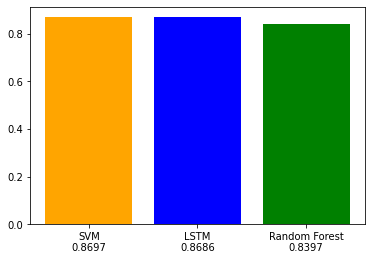

In [ ]:
accuracies = [accuracy_svm, accuracy_lstm, accuracy_rf]
names = ["SVM\n"+str(accuracy_svm)[:6], "LSTM\n"+str(accuracy_lstm)[:6], "Random Forest\n"+str(accuracy_rf)[:6]]
plt.bar(names, accuracies, color = ['orange', 'blue', 'green'])